In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [13]:
from app_utils import get_player_features, get_all_players_for_round
import pandas as pd
df_info=get_player_features('Witsel', 14)

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import numpy as np
import joblib
from sqlalchemy import create_engine

## 1. Get data

In [15]:
username = 'rodrigo'
host = 'localhost'           
port = '5432'               
database = 'futmondo_full_players_info'

engine = create_engine(f'postgresql+psycopg2://{username}@{host}:{port}/{database}')
# query = "SELECT * FROM full_training_data"
query= """SELECT *
    FROM full_training_data;"""

df = pd.read_sql(query, engine)
df.shape

(2064, 39)

In [17]:
df.columns

Index(['player_id', 'name', 'role', 'round', 'team_id', 'home_average',
       'away_average', 'overall_average', 'current_price', 'matches_played',
       'rating', 'match_minus_1', 'match_minus_2', 'last_2_average',
       'target_points', 'unique_id', 'team', 'matchup_prob_win',
       'matchup_prob_draw', 'matchup_prob_loss', 'is_home', 'opponent',
       'form_trend', 'home_away_diff', 'price_per_point', 'price_efficiency',
       'recent_momentum', 'home_form_interaction', 'away_form_interaction',
       'location_adjusted_average', 'matchup_strength',
       'team_expected_performance', 'delantero_matchup_bonus',
       'centrocampista_matchup_bonus', 'defensa_matchup_bonus',
       'portero_matchup_bonus', 'home_matchup_boost', 'difficult_matchup',
       'easy_matchup'],
      dtype='object')

In [20]:
df.role.value_counts()

role
defensa           732
delantero         572
centrocampista    552
portero           208
Name: count, dtype: int64

In [10]:
# df=pd.read_csv('data/final_dataset/futmondo_final_dataset.csv')
# df.shape

## 2. Build the model

In [12]:
# Corrected feature columns
feature_columns = [
    'home_average',
    'away_average', 
    'rating',       # given by futmondo
    'overall_average', 
    'last_2_average',  # Changed from last_3_average
    'current_price',
    'is_home',  # Removed is_home_target (duplicate)
    'match_minus_1',
    'match_minus_2',  # Removed match_minus_3 (not available)
    'matchup_prob_win', 
    'matchup_prob_draw', 
    'matchup_prob_loss', 
    'form_trend', 
    'home_away_diff', 
    'price_per_point',  # Changed from price_vs_max
    # 'price_efficiency',  # Changed from price_volatility
    'recent_momentum', 
    'home_form_interaction',
    'away_form_interaction',
    'location_adjusted_average',  # Added new feature
    'matchup_strength',
    'team_expected_performance', 
    'delantero_matchup_bonus',
    'centrocampista_matchup_bonus', 
    'defensa_matchup_bonus',
    'portero_matchup_bonus', 
    'home_matchup_boost', 
    'difficult_matchup',
    'easy_matchup'
]

# Drop rows where target_points or any feature is NaN
df_clean = df.dropna(subset=['target_points'] + feature_columns)
X = df_clean[feature_columns]
y = df_clean['target_points']

In [15]:
df.isna().sum()

player_id                         0
name                              0
role                              0
round                             0
team_id                           0
home_average                      8
away_average                      8
overall_average                  16
current_price                     0
matches_played                    0
rating                            0
match_minus_1                     0
match_minus_2                     0
last_2_average                    0
target_points                   525
unique_id                         0
team                              0
matchup_prob_win                  0
matchup_prob_draw                 0
matchup_prob_loss                 0
is_home                           0
opponent                          0
form_trend                       16
home_away_diff                   16
price_per_point                  16
price_efficiency                 16
recent_momentum                   0
home_form_interaction       

In [16]:
df_clean.shape

NameError: name 'df_clean' is not defined

In [15]:
# # Check for NaN values first
# print("NaN values per column:")
# print(X.isna().sum())
# print(f"\nTotal NaN values: {X.isna().sum().sum()}")

# # Option 1: Drop rows with NaN values (if not too many)
# X_clean = X.dropna()
# y_clean = y[X_clean.index]

# print(f"\nRows before: {len(X)}, Rows after: {len(X_clean)}")

In [16]:
# Scale features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Ensemble model with multiple algorithms
gb_model = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

ridge_model = Ridge(alpha=10.0, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

# Voting ensemble combines predictions from all models
model = VotingRegressor(
    estimators=[
        ('gb', gb_model),
        ('rf', rf_model),
        ('ridge', ridge_model)
    ],
    weights=[2, 2, 1]  # Give more weight to tree-based models
)

# Train the ensemble
model.fit(X_train, y_train)

,estimators,"[('gb', ...), ('rf', ...), ...]"
,weights,"[2, 2, ...]"
,n_jobs,None
,verbose,False
,loss,'squared_error'
,learning_rate,0.05
,n_estimators,150
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10
,min_samples_leaf,4


In [17]:
# ===== PREDICTIONS =====
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Create predictions dataframe for test set
test_indices = len(y_test)
predictions_df = pd.DataFrame({
    'actual_points': y_test,
    'predicted_points': y_pred_test,
    'error': y_test - y_pred_test,
    'abs_error': np.abs(y_test - y_pred_test)})

In [18]:
# # Add original features (unscaled) for context
# X_test_unscaled = X.iloc[y_test.index] if hasattr(y_test, 'index') else X.iloc[-len(y_test):]
# predictions_df = pd.concat([predictions_df.reset_index(drop=True), 
#                             X_test_unscaled.reset_index(drop=True)], axis=1)

# print("===== PREDICTIONS SAMPLE =====")
# print(predictions_df[['actual_points', 'predicted_points', 'error', 'abs_error', 
#                       'overall_average', 'last_3_average', 'is_home_target']].head(10))
# print(f"\nMean Absolute Error: {predictions_df['abs_error'].mean():.3f}")
# print(f"Root Mean Squared Error: {np.sqrt((predictions_df['error']**2).mean()):.3f}")

In [19]:
# ===== FEATURE IMPORTANCE =====
# Access the fitted models from the VotingRegressor
gb_importance = model.named_estimators_['gb'].feature_importances_
rf_importance = model.named_estimators_['rf'].feature_importances_

# Average importance across models
avg_importance = (gb_importance * 2 + rf_importance * 2) / 4

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': avg_importance,
    'gb_importance': gb_importance,
    'rf_importance': rf_importance
}).sort_values('importance', ascending=False)

print("\n===== FEATURE IMPORTANCE =====")
print(feature_importance_df)


===== FEATURE IMPORTANCE =====
                         feature  importance  gb_importance  rf_importance
5                  current_price    0.191427       0.259845       0.123008
18     location_adjusted_average    0.136822       0.142769       0.130875
15               recent_momentum    0.069255       0.055722       0.082787
12                    form_trend    0.059361       0.075756       0.042967
3                overall_average    0.047181       0.036712       0.057651
7                  match_minus_1    0.045290       0.046264       0.044317
1                   away_average    0.038563       0.033263       0.043862
14               price_per_point    0.038470       0.038343       0.038597
4                 last_2_average    0.035810       0.016379       0.055241
16         home_form_interaction    0.033481       0.027588       0.039374
0                   home_average    0.032930       0.020460       0.045400
13                home_away_diff    0.032290       0.036019       0.

Save the model

In [20]:
import joblib

# After training your model
model_package = {
    'model': model,
    'scaler': scaler,
    'feature_columns': feature_columns
}

joblib.dump(model_package, '../data/model/fantasy_model_complete.pkl')

['../data/model/fantasy_model_complete.pkl']

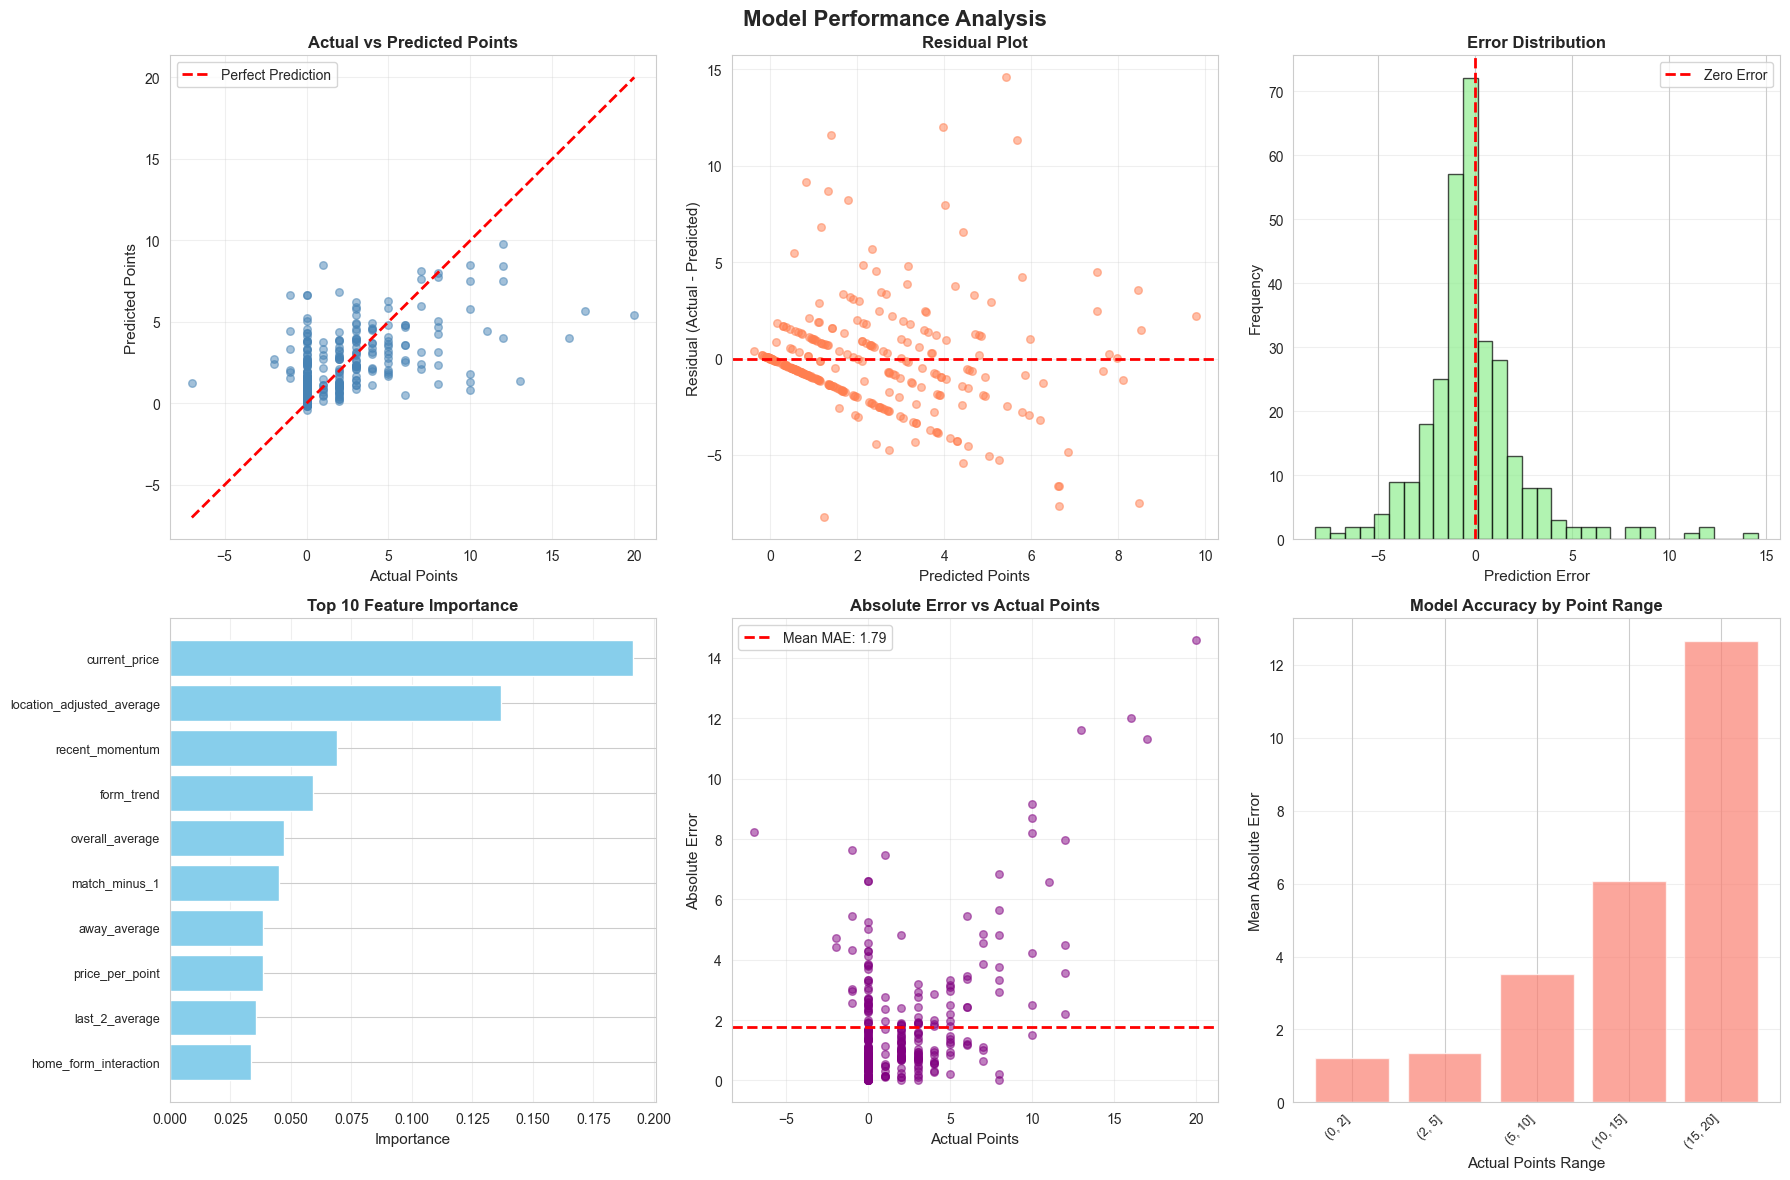


===== DETAILED PERFORMANCE METRICS =====
Mean Absolute Error (MAE): 1.787
Root Mean Squared Error (RMSE): 2.761
Median Absolute Error: 1.074
Max Error: 14.588
Predictions within 2 points: 72.5%
Predictions within 5 points: 93.5%

R² Score: 0.286


In [21]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted Scatter Plot
axes[0, 0].scatter(predictions_df['actual_points'], predictions_df['predicted_points'], 
                   alpha=0.5, s=30, c='steelblue')
# Perfect prediction line
min_val = min(predictions_df['actual_points'].min(), predictions_df['predicted_points'].min())
max_val = max(predictions_df['actual_points'].max(), predictions_df['predicted_points'].max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Points', fontsize=11)
axes[0, 0].set_ylabel('Predicted Points', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted Points', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot (errors)
axes[0, 1].scatter(predictions_df['predicted_points'], predictions_df['error'], 
                   alpha=0.5, s=30, c='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Points', fontsize=11)
axes[0, 1].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[0, 2].hist(predictions_df['error'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 2].set_xlabel('Prediction Error', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Feature Importance (Top 10)
top_features = feature_importance_df.head(10)
axes[1, 0].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 0].set_xlabel('Importance', fontsize=11)
axes[1, 0].set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 5. Absolute Error vs Actual Points
axes[1, 1].scatter(predictions_df['actual_points'], predictions_df['abs_error'], 
                   alpha=0.5, s=30, c='purple')
axes[1, 1].axhline(y=predictions_df['abs_error'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean MAE: {predictions_df["abs_error"].mean():.2f}')
axes[1, 1].set_xlabel('Actual Points', fontsize=11)
axes[1, 1].set_ylabel('Absolute Error', fontsize=11)
axes[1, 1].set_title('Absolute Error vs Actual Points', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Accuracy Bins
bins = [0, 2, 5, 10, 15, 20, 30]
predictions_df['actual_bin'] = pd.cut(predictions_df['actual_points'], bins=bins)
accuracy_by_bin = predictions_df.groupby('actual_bin', observed=True)['abs_error'].mean()
axes[1, 2].bar(range(len(accuracy_by_bin)), accuracy_by_bin.values, color='salmon', alpha=0.7)
axes[1, 2].set_xticks(range(len(accuracy_by_bin)))
axes[1, 2].set_xticklabels([str(x) for x in accuracy_by_bin.index], rotation=45, ha='right', fontsize=9)
axes[1, 2].set_xlabel('Actual Points Range', fontsize=11)
axes[1, 2].set_ylabel('Mean Absolute Error', fontsize=11)
axes[1, 2].set_title('Model Accuracy by Point Range', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional summary statistics
print("\n===== DETAILED PERFORMANCE METRICS =====")
print(f"Mean Absolute Error (MAE): {predictions_df['abs_error'].mean():.3f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt((predictions_df['error']**2).mean()):.3f}")
print(f"Median Absolute Error: {predictions_df['abs_error'].median():.3f}")
print(f"Max Error: {predictions_df['abs_error'].max():.3f}")
print(f"Predictions within 2 points: {(predictions_df['abs_error'] <= 2).sum() / len(predictions_df) * 100:.1f}%")
print(f"Predictions within 5 points: {(predictions_df['abs_error'] <= 5).sum() / len(predictions_df) * 100:.1f}%")
print(f"\nR² Score: {model.score(X_test, y_test):.3f}")

In [22]:
# Group highly correlated features and keep only the best from each group
correlation_matrix = df[feature_columns].corr()
correlation_matrix

,home_average,away_average,rating,overall_average,last_2_average,current_price,is_home,match_minus_1,match_minus_2,matchup_prob_win,...,location_adjusted_average,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
home_average,1.000000,0.545616,0.697646,0.846846,0.553156,0.594546,-0.011431,0.449738,0.464055,0.109638,...,0.785065,0.101167,0.104292,0.088983,0.055651,-0.006268,-0.108722,0.035431,-0.041973,0.077166
away_average,0.545616,1.000000,0.548845,0.854663,0.487351,0.482978,-0.001364,0.403995,0.401052,0.073839,...,0.749043,0.071852,0.072713,0.072138,0.013820,-0.009161,-0.049994,0.014688,-0.029988,0.055592
rating,0.697646,0.548845,1.000000,0.686870,0.540896,0.844936,-0.011883,0.439373,0.454592,0.196765,...,0.622871,0.186741,0.190617,0.149527,0.111897,-0.092282,-0.062406,0.048444,-0.072556,0.190465
overall_average,0.846846,0.854663,0.686870,1.000000,0.565402,0.601309,-0.006825,0.461557,0.472008,0.123555,...,0.843697,0.115706,0.118661,0.076971,0.043746,0.002241,-0.076453,0.034652,-0.051924,0.094642
last_2_average,0.553156,0.487351,0.540896,0.565402,1.000000,0.432726,-0.019265,0.827309,0.825362,0.025706,...,0.508407,0.024780,0.025158,0.074674,0.011599,-0.047400,-0.030937,0.000084,0.018881,0.020767
current_price,0.594546,0.482978,0.844936,0.601309,0.432726,1.000000,-0.006266,0.353419,0.361758,0.255701,...,0.538581,0.239124,0.245347,0.239200,0.121597,-0.143236,-0.069294,0.068967,-0.091953,0.265955
is_home,-0.011431,-0.001364,-0.011883,-0.006825,-0.019265,-0.006266,1.000000,-0.041631,0.009922,0.440627,...,0.087443,0.445634,0.445134,0.079338,0.084937,0.082100,0.030863,0.934147,-0.225633,0.227013
match_minus_1,0.449738,0.403995,0.439373,0.461557,0.827309,0.353419,-0.041631,1.000000,0.365666,-0.002416,...,0.367458,-0.002385,-0.002402,0.059344,0.008301,-0.047542,-0.028667,-0.022494,0.035134,-0.004372
match_minus_2,0.464055,0.401052,0.454592,0.472008,0.825362,0.361758,0.009922,0.365666,1.000000,0.045020,...,0.472242,0.043455,0.044098,0.064080,0.010875,-0.030752,-0.022446,0.022748,-0.004030,0.038802
matchup_prob_win,0.109638,0.073839,0.196765,0.123555,0.025706,0.255701,0.440627,-0.002416,0.045020,1.000000,...,0.178325,0.988114,0.994751,0.196945,0.178808,0.178400,0.064279,0.648977,-0.573741,0.678657


In [23]:
df_clean.head(2)

,player_id,name,role,round,team_id,home_average,away_average,overall_average,current_price,matches_played,...,location_adjusted_average,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
0,576cb7e161f452a36e9181f4,Cervi,delantero,14,504e581e4d8bec9a670000d9,0.000000,0.000,0.0,1000000,0,...,0.000,0.222378,1.696362,0.947967,0.000000,0.0,0.0,0.236992,0,0
1,520d1ce5a776cc826b000026,Lucas Torró,centrocampista,14,504e581e4d8bec9a670000d1,4.428571,3.625,4.0,9153244,15,...,3.625,-0.117237,1.168529,0.000000,0.342919,0.0,0.0,0.000000,0,0


In [21]:
df_clean

,player_id,name,role,round,team_id,home_average,away_average,overall_average,current_price,matches_played,...,location_adjusted_average,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
0,576cb7e161f452a36e9181f4,Cervi,delantero,14,504e581e4d8bec9a670000d9,0.000000,0.000000,0.000000,1000000,0,...,0.000000,0.222378,1.696362,0.947967,0.000000,0.000000,0.0,0.236992,0,0
1,520d1ce5a776cc826b000026,Lucas Torró,centrocampista,14,504e581e4d8bec9a670000d1,4.428571,3.625000,4.000000,9153244,15,...,3.625000,-0.117237,1.168529,0.000000,0.342919,0.000000,0.0,0.000000,0,0
2,57583b4733dbe3424c05e8ee,Luis Milla,centrocampista,14,504e581e4d8bec9a670000cd,6.857143,5.625000,6.200000,60084242,15,...,6.857143,0.184980,1.615478,0.000000,0.516598,0.000000,0.0,0.215249,0,0
3,52079128fa700fba29000016,Pere Milla,delantero,14,504e581e4d8bec9a670000d0,5.500000,6.333333,5.857143,21071841,14,...,6.333333,-0.222378,1.029227,0.503210,0.000000,0.000000,0.0,0.000000,0,0
4,5590e613b804493642903d44,Yeray,defensa,14,504e581e4d8bec9a670000c9,0.000000,0.000000,0.000000,1000000,0,...,0.000000,0.164468,1.606073,0.000000,0.000000,0.582234,0.0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,68f3b8b9dd3614500b418a49,Lass,centrocampista,16,520347e4b8d07d930b00000f,0.000000,1.000000,1.000000,1000000,1,...,1.000000,-0.192505,1.111609,0.000000,0.364936,0.000000,0.0,0.000000,0,0
1543,68fe7b135fa52f03fe008bad,Osambela,centrocampista,16,504e581e4d8bec9a670000d1,7.000000,1.000000,4.000000,1000000,2,...,1.000000,-0.448683,0.743100,0.000000,0.230140,0.000000,0.0,0.000000,1,0
1544,690c69e2c2cdbf03b2f132e8,Selton,centrocampista,16,504e581e4d8bec9a670000c9,3.500000,2.000000,2.750000,1000000,4,...,2.000000,-0.049069,1.319981,0.000000,0.442859,0.000000,0.0,0.000000,0,0
1545,690f6102072c5e03d67ac3e5,Morcillo,delantero,16,52038563b8d07d930b00008a,0.000000,2.000000,2.000000,1000000,1,...,0.000000,-0.211127,1.082414,0.587082,0.000000,0.000000,0.0,0.146770,1,0
